In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/data.csv',encoding='latin-1')

In [ ]:
df.columns = ["Target","ids","date","flag","user","text"]

In [ ]:
dic = {0 : "NEGATIVE", 2 : "NEUTRAL" , 4: "POSITIVE"}

def con(x):
    return dic[int(x)]

df.Target = df.Target.apply(lambda x:con(x))

In [ ]:
df.head()

,Target,ids,date,flag,user,text
0,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,NEGATIVE,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


<BarContainer object of 2 artists>

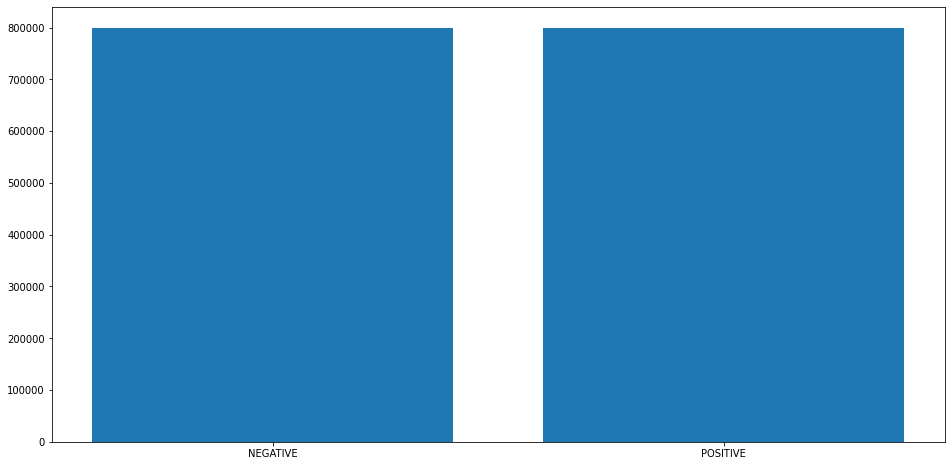

In [ ]:
from collections import Counter

dic2 = Counter(df.Target)
plt.figure(figsize=(16,8))
plt.bar(dic2.keys(),dic2.values())


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE,' ',str(text).lower()).strip()
    l = []
    for i in text.split():
        if i not in stop_words:
            l.append(stemmer.stem(i))
    return " ".join(l)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.text = df.text.apply(lambda x:preprocess(x))

**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
document = [i.split() for i in df.text]

In [ ]:
import gensim

#W2V_SIZE = 300
# W2V_WINDOW = 7
W2V_SIZE = 150
W2V_WINDOW = 4
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(
    size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=8
)

size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

In [ ]:
w2v_model.build_vocab(document)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 26897


In [ ]:
w2v_model.train(document,total_examples=len(document),epochs=32)

(325052935, 369138272)

In [ ]:
w2v_model.most_similar("iphon")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('3g', 0.7333182692527771),
 ('itouch', 0.7161034345626831),
 ('blackberri', 0.7155922055244446),
 ('firmwar', 0.6931616067886353),
 ('2g', 0.6896428465843201),
 ('devic', 0.6787474751472473),
 ('handset', 0.6666049957275391),
 ('g1', 0.664409339427948),
 ('softwar', 0.6599547266960144),
 ('mobil', 0.6529595851898193)]

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total Words : ", vocab_size)

Total Words :  248696


In [ ]:
from keras.preprocessing.sequence import pad_sequences
SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.Target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train.Target.tolist())

y_train = encoder.transform(df_train.Target.tolist())
y_test = encoder.transform(df_test.Target.tolist())

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)


y_train (1279999,)
y_test (320000,)
y_train (1279999, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1279999, 300)
y_train (1279999, 1)

x_test (320000, 300)
y_test (320000, 1)


Embedding Layer

In [ ]:
embedding_matrix = np.zeros((vocab_size,W2V_SIZE))

for word,i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(248696, 150)


In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH,trainable=False)

Build Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          37304400  
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 37,404,901
Trainable params: 100,501
Non-trainable params: 37,304,400
_________________________________________________________________


Compile Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks


In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss',patience=5,cooldown=0),
             EarlyStopping(monitor='val_acc',min_delta=1e-4,patience=5)]

Train

In [ ]:
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

# SEQUENCE_LENGTH = 200
# EPOCHS = 4
# BATCH_SIZE = 777

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

1125/1125 [==============================] - 9038s 8s/step - loss: 0.5313 - accuracy: 0.7294 - val_loss: 0.4840 - val_accuracy: 0.7690 - lr: 0.0010


In [ ]:
history

In [ ]:
# SEQUENCE_LENGTH = 300
# EPOCHS = 1
# BATCH_SIZE = 1024

# # SEQUENCE_LENGTH = 200
# # EPOCHS = 4
# # BATCH_SIZE = 777

# history2 = model.fit(x_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_split=0.1,
#                     verbose=1,
#                     callbacks=callbacks)

In [ ]:

score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 556s 2s/step - loss: 0.4824 - accuracy: 0.7704

ACCURACY: 0.7704343795776367
LOSS: 0.48240533471107483


In [ ]:
acc = history.history['acccuracy']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

KeyError: ignored

In [ ]:
history.history

{'accuracy': [0.7293773889541626],
 'loss': [0.531332790851593],
 'lr': [0.001],
 'val_accuracy': [0.7690078020095825],
 'val_loss': [0.48400431871414185]}

In [ ]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict('kill')

{'elapsed_time': 0.13698458671569824,
 'label': 'NEGATIVE',
 'score': 0.08149087429046631}